Notebook demonstrate the text classification (positive/negative moview reviews).
The underlying problem is sentiment analysis.
The data contains 50000 moview reviews. Further split into 25000 for train set and 25000 for test set. The train and test set are balanced, meaning they contain equal number of positives and negatives.

In [34]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [35]:
print(tf.__version__)

2.8.0


We download and extract the dataset. Explore the directory structure.

In [36]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [37]:
os.listdir(dataset_dir)

['imdb.vocab', 'imdbEr.txt', 'test', 'README', 'train']

In [38]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_pos.txt',
 'neg',
 'unsup',
 'urls_unsup.txt',
 'urls_neg.txt',
 'unsupBow.feat',
 'labeledBow.feat',
 'pos']

The aclImdb/train/pos and aclImdb/train/neg directories contain many text files, each of which is a single movie review.

In [39]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


# **Load the dataset**
We will use the helpful **text_dataset_from_directory** utility, which expects a directory structure as follows.

```
main directory/
...class a/
      a_file_1
      a_file_2
...class b/
      b_file_1
      b_file_2
```

To prepare the dataset for binary classification, we need 2 folders on the disk. We will create 2 folders on disk corresponding to class a and class b.
These will be pos and neg movie reviews.
We won't need any other folders, thus we will remove those.

**tf.data** is the powerful tool to work with the data.

As per general practice of ML, we should split the dataset into train, validation, test sets.

Our current data is already splited into train and test set with validation set missing. 
We will create validation set with 80:20 proportion of train set.



In [40]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [41]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


We will iterate over few examples of the traning data to see data.

In [42]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

Obsevation on new data: 


```
<br>
```  and few punctuation are present in data. We should handle it.

Also, we can use class_names property in the dataset to see what Label 0 and 1 represents

In [43]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


Following code, we create validation set. 

Note - Random seed or shuffle = false must be provided as subset argument to prevent overlap between train and validation set.

In [44]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [45]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


## **Now we should prepare the training data**

Few concepts - Standardization, Tokenization, Vectorization

**Standardization** : refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset.

**Tokenization**: refers to spllitting string into tokens.

**Vectorization**: refers to converting tokens into numbers so that they could be fed to NN.

Refer to tf.keras.layers.TextVectorization  in Keras.

In [46]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

TextVectorization does removes punctuations, and convert the text to lower case. But, it won't remove html tag `<br>` thus, we wrote custom standardization function to strip html tags.

**NOTE**

**Training and testing skew:  (training-serving skew)**

It is important to preprocess the data at train and test time. 

To achieve this, TextVectorization Layer can be included directly in the model. 


In [49]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

The above TextVectorization layer is created. 

output_mode = 'int' will create unique integer indices for each token.

sequence_length = will truncate or pad the sequences to the constant value.

We will call adapt to fit the state of the preprocessing layer to the training data.

This will cause the model to build the index of strings to integers.


**Note**

It's important to only use your training data when calling adapt (using the test set would leak information).

In [50]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Let's create a function to see the result of using this layer to preprocess some data.

In [51]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [52]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

We can lookup the token (string) that each integer corresponds to by calling .get_vocabulary() on the layer.

In [53]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


We are ready to create model. Before that, we will apply the TextVectorization layer to the train, validation and test set.

In [54]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

**Performance**

Following are the 2 important methods we use for loading data to make sure that I/O does not become a blocker.

`.cache()` = keeps the data in memory after it is loaded off disk.

This will ensure that dataset doesnt become blocker while training the model.

What if the dataset is loo large to fit into the memory? 
Ans: We can also create a performant on-disk cache, which is more efficient to read than many small files.

`.prefetch()` = overlaps data preprocessing and model execution while training.

There are more techniques of data performance optimization - https://www.tensorflow.org/guide/data_performance


In [55]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

**CREATE MODEL**

In [56]:
embedding_dim = 16

In [57]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_2 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
________________________________________________

**The layers are stacked sequentially to build the classifier.**

1. The first layer is Embedding layer.
Each takes up the integer coded reviews and looks up an embedding vector for each word-index.
These vectors are learned as the model trains.
The vectors add a dimension to the output array.
The resulting dimension are (batch, sequence, embedding). To learn more - https://www.tensorflow.org/text/guide/word_embeddings

2. GlobalAveragePooling1D returns a fixed length output vector for each example by averaging over sequence dimension. 
This allows the model to handle the input of variable length.

3. The fixed length output vector is piped through the fully connected (dense) layer with 16 hidden units.

4. The last layer is connected to the single output node.


**Loss Function and Optimizer**

The model needs the loss function and the optimizer for the training. 

Since this is the binary classification problem and the model outputs the probability (a single-unit layer with sigmoid activitation), we will use losses.BinaryCrossentropy loss function

In [58]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

**Train the model**

We will train the model by passing the dataset object to the fit method.

In [59]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 11s 16ms/step - loss: 0.6643 - binary_accuracy: 0.6946 - val_loss: 0.6150 - val_binary_accuracy: 0.7736
Epoch 2/10
625/625 [==============================] - 4s 7ms/step - loss: 0.5484 - binary_accuracy: 0.8025 - val_loss: 0.4979 - val_binary_accuracy: 0.8228
Epoch 3/10
625/625 [==============================] - 4s 7ms/step - loss: 0.4440 - binary_accuracy: 0.8450 - val_loss: 0.4197 - val_binary_accuracy: 0.8468
Epoch 4/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3778 - binary_accuracy: 0.8671 - val_loss: 0.3732 - val_binary_accuracy: 0.8610
Epoch 5/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3349 - binary_accuracy: 0.8805 - val_loss: 0.3447 - val_binary_accuracy: 0.8684
Epoch 6/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3053 - binary_accuracy: 0.8892 - val_loss: 0.3257 - val_binary_accuracy: 0.8734
Epoch 7/10
625/625 [==============================] - 4s 7ms/s

**Evaluate the mode**

2 values will be returned - Loss and Accuracy.

In [60]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 8s 10ms/step - loss: 0.3100 - binary_accuracy: 0.8732
Loss:  0.3100190758705139
Accuracy:  0.873199999332428


This fairly naive approach got the accuracy of 87%

We will create the plot of accuracy and loss over time.

`model.fit()` returns the `History` object.

It contains the dictionary with everything that happened during the training. 

In [27]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

There are four entries: one for each monitored metric during training and validation. You can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

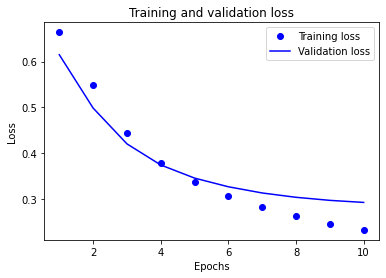

In [61]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

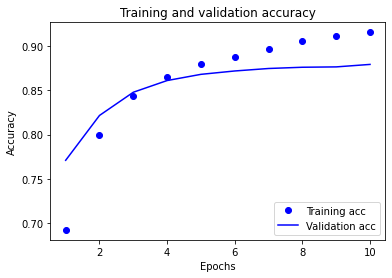

In [62]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

General Learning scenario:

**Notice the training loss decreases with each epoch and the training accuracy increases with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.**

Overfitting scenario:

**This isn't the case for the validation loss and accuracy—they seem to peak before the training accuracy. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before.**

Over-Optimization Scenario:

**After this point, the model over-optimizes and learns representations specific to the training data that do not generalize to test data.**

How to stop overfitting from happening?

**For this particular case, you could prevent overfitting by simply stopping the training when the validation accuracy is no longer increasing.**

One way to do so is to use the tf.keras.callbacks.EarlyStopping callback.

EXPORT THE MODEL

In the code above, you applied the TextVectorization layer to the dataset before feeding text to the model. 

If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the TextVectorization layer inside your model. To do so, you can create a new model using the weights you just trained.

In [63]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 9s 11ms/step - loss: 0.3100 - accuracy: 0.8732
0.873199999332428


**Inference on new data**

To get predictions for new examples, you can simply call model.predict()

In [33]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)


array([[0.59790313],
       [0.41940245],
       [0.33875468]], dtype=float32)

Including the text preprocessing logic inside your model enables you to export a model for production that simplifies deployment, and reduces the potential for train/test skew. 

https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew

There is a performance difference to keep in mind when choosing where to apply your TextVectorization layer. Using it outside of your model enables you to do asynchronous CPU processing and buffering of your data when training on GPU. So, if you're training your model on the GPU, you probably want to go with this option to get the best performance while developing your model, then switch to including the TextVectorization layer inside your model when you're ready to prepare for deployment.

Visit this tutorial to learn more about saving models.

https://www.tensorflow.org/tutorials/keras/save_and_load

